<a href="https://colab.research.google.com/github/Chandang786/py/blob/master/incident.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to My kernal 
# Problem statement: 
 All support teams are majorly depend upon Request center/Incident to track issues and health of their server, disk, and technology related issue. Here I come up with idea to track most occured issues as per incident count and then find what is the major contributer casue for this issue. So we can easlt track and resolve issue before we are flooded with same kind of issues.
 

1. collect dump
2. get all summary data
3. tokenize the summary into words
4. count the repeated issues
5. define stopkeywords
6. get the top 10 keywords


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import nltk
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
incident_dump = pd.read_csv('gdrive/My Drive/ML/updated_report.csv',encoding='cp1252')

In [6]:
# Data cleaning and formating

incident_dump['Closed Date'] = pd.to_datetime(incident_dump['Closed Date'],format = '%d/%m/%Y, %H:%M:%S %p')
incident_dump['Submit Date'] = pd.to_datetime(incident_dump['Submit Date'],format = '%d/%m/%Y, %H:%M:%S %p')


incident_dump.dropna(inplace=True)

incident_dump.drop(['Assignee+'],axis=1,inplace=True)
incident_dump.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 999
Data columns (total 6 columns):
Incident ID*+    923 non-null object
Closed Date      923 non-null datetime64[ns]
Summary*         923 non-null object
Resolution       923 non-null object
Submit Date      923 non-null datetime64[ns]
Notes            923 non-null object
dtypes: datetime64[ns](2), object(4)
memory usage: 50.5+ KB


In [7]:
from nltk.tokenize import word_tokenize,wordpunct_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist

list_of_words=[]
for i in incident_dump['Summary*']:
    list_of_words.append(word_tokenize(i))
    
#list_of_words

LookupError: ignored

In [9]:
# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorize = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorize.build_analyzer()

def wordcounts(summary):
    word_tocken = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(summary):
        key_value_pair = {}
        # find counts of the vocabularies and transform to array 
        words_array = vectorize.fit_transform([summary]).toarray()
        # vocabulary and index (index of w)
        vc = vectorize.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            key_value_pair[v]=k # key_value_pair -> index:word 
        for index,value in enumerate(words_array[0]):
            word_tocken[key_value_pair[index]] = value # c -> word:count
    return  word_tocken
        

    
#collecting tockenize of Summary Data
incident_dump['words'] = incident_dump['Summary*'].apply(wordcounts)
incident_dump['notes_words'] = incident_dump['Notes'].apply(wordcounts)


# list of most occuring Issues
count_word = {}

for d in incident_dump['words']:
    for k,v in d.items():
        if(k not in count_word):
            count_word[k] = v
        else:
            count_word[k] = count_word[k] + v
            
            
# droping stop words
stop_word = ['{C}','-','issue','(1480)','2016','DB','is','failed.','Issue:']
sw = pd.read_csv('gdrive/My Drive/ML/stop_words.csv')
sw.drop('Unnamed: 1',axis=1,inplace=True)
sw.append(stop_word)
for i in sw:
    if(i in count_word):
        del count_word[i]
        
for i in stop_word:
    if(i in count_word):
        del count_word[i]
            
            
list_of_issues = sorted(count_word.items(), key=lambda x: x[1], reverse=True)
list_of_issues[0:10]


[('cloud', 664),
 ('hosts', 664),
 ('cluster', 420),
 ('failed', 333),
 ('server', 332),
 ('mssqlserver', 283),
 ('service', 234),
 ('microsoft', 201),
 ('resource', 199),
 ('sql', 188)]

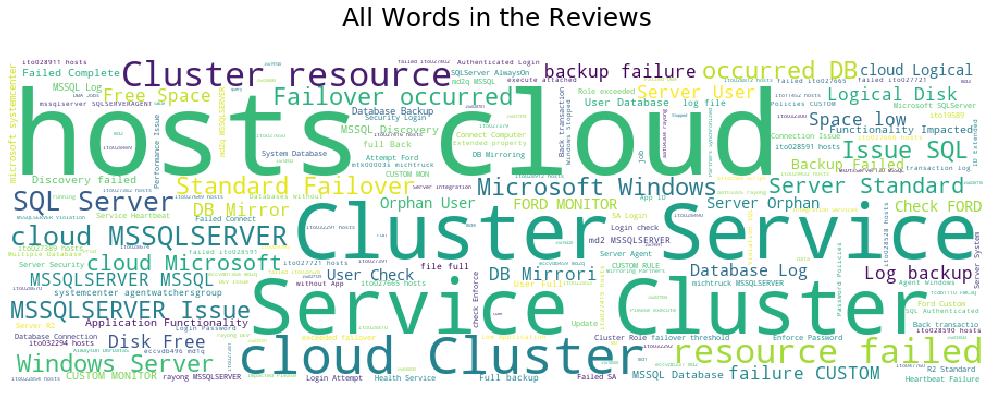

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

rt = incident_dump['Summary*']
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))

plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=25)
plt.axis('off')
plt.show()

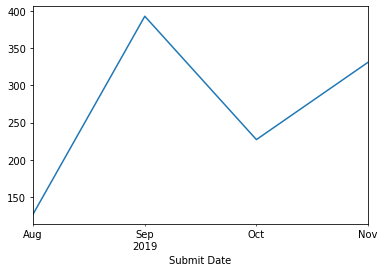

In [12]:

#Selected Incident types
selectedwords = ['cluster','failover','backup','mirror','disk','orphan','backup','discovery','mirroring','login','password'
                ,'heartbeat','performance']
#dfwc = data.copy()


def selectedcount(dic,word):
    '''
    Count of each word occured in summary
    '''
    if word in dic:
        return dic[word]
    else:
        return 0

    
for word in selectedwords:
    incident_dump[word] = incident_dump['words'].apply(selectedcount,args=(word,))


# Month wise issue frequency    
#incident_dump['month'] = pd.DatetimeIndex(incident_dump['Submit Date']).month



#monthly_occurance = incident_dump.groupby(['month']).sum()
ds = incident_dump.set_index('Submit Date')
monthly_occurance = ds.resample('MS').sum()


Result = []

#Threshold value set to 30

previous_value = 30 

for next_value in monthly_occurance.sum(axis=1):
    if( (next_value > previous_value)  & ((next_value - previous_value)>10)):
        Result.append(1)
    else: Result.append(0)
    previous_value = next_value
monthly_occurance['Result'] = Result  

monthly_occurance.drop('Result',axis=1).sum(axis=1)
ds[ds['cluster']>0]

monthly_occurance.drop(['Result'],axis=1).sum(axis=1).plot()

,mean,std,min,25%,50%,75%,max
cluster,105.00,93.815422,16.0,38.50,90.0,156.50,224.0
failover,41.00,44.467216,6.0,9.00,28.0,60.00,102.0
backup,33.75,14.430870,20.0,26.75,30.5,37.50,54.0
mirror,17.75,20.188693,0.0,2.25,14.0,29.50,43.0
disk,20.00,28.809721,2.0,5.00,7.5,22.50,63.0
orphan,14.50,11.930353,6.0,7.50,10.0,17.00,32.0
discovery,10.75,5.377422,4.0,7.75,11.5,14.50,16.0
mirroring,4.75,6.946222,0.0,0.75,2.0,6.00,15.0
login,9.00,5.354126,2.0,7.25,9.5,11.25,15.0
password,5.25,4.272002,2.0,2.00,4.0,7.25,11.0


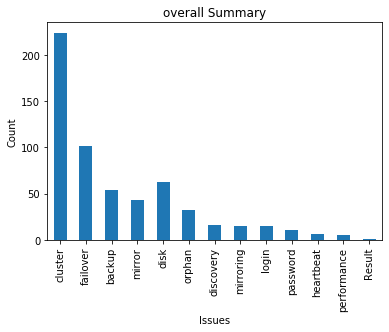

In [13]:
d =monthly_occurance.describe().T.drop('count',axis=1)


d['max'].plot(kind='bar')
plt.xlabel('Issues')
plt.ylabel('Count')
plt.title('overall Summary')
d

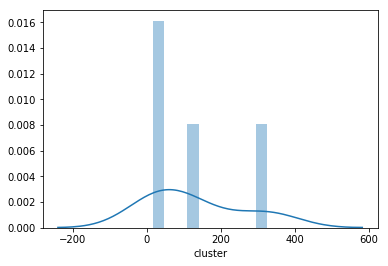

In [0]:
#visualization

import seaborn as sns
sns.distplot(monthly_occurance['cluster'],kde=True,bins=10)



In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_curve,roc_auc_score,confusion_matrix



test_x = monthly_occurance.drop('Result',axis=1)
test_y = monthly_occurance['Result']
X_train, X_test, y_train, y_test = train_test_split(test_x, test_y, test_size=0.2, random_state=42)

# create object of Logistic Regression
model = LogisticRegression()
start=dt.datetime.now()
#Fit data model
model.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
#Predict Data
predict =model.predict(X_test)
print('Model Score: ',model.score(X_test,y_test))

print('Confusion Matrix: \n', confusion_matrix(y_test.values,predict))


print(classification_report(y_test.values,predict,target_names=['Green','Red']))



Elapsed time:  0:00:00
Model Score:  0.0
Confusion Matrix: 
 [[0 0]
 [1 0]]
              precision    recall  f1-score   support

       Green       0.00      0.00      0.00         0
         Red       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         1
   macro avg       0.00      0.00      0.00         1
weighted avg       0.00      0.00      0.00         1



C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\chand\Anaconda3\lib\sit

In [0]:
from sklearn.naive_bayes import MultinomialNB

start=dt.datetime.now()
model1 = MultinomialNB()
model1.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start),'\n')

print('Model Score: ',model1.score(X_test,y_test),'\n')

print('Confusion Matrix: \n', confusion_matrix(y_test.values,predict))


print(classification_report(y_test.values,predict,target_names=['Green','Red']))

Elapsed time:  0:00:00 

Model Score:  0.0 

Confusion Matrix: 
 [[0 0]
 [1 0]]
              precision    recall  f1-score   support

       Green       0.00      0.00      0.00         0
         Red       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         1
   macro avg       0.00      0.00      0.00         1
weighted avg       0.00      0.00      0.00         1



In [36]:
#!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
#!pip install pyaudio
import pyaudio
pyaudio.pa.__file__

'/usr/local/lib/python3.6/dist-packages/_portaudio.cpython-36m-x86_64-linux-gnu.so'

In [32]:
#!pip install speechrecognition
#!pip install pyttsx3
#!pip install gtts
#!pip install pyaudio

import speech_recognition as sr
import os
 # converts the text to speech   
import pyttsx3  
from gtts import  gTTS

r = sr.Recognizer()

myobj = gTTS(text='Hi. How can I help?', lang='en', slow=False)
myobj.save('Welcome.mp3')
os.system("Welcome.mp3")
with sr.Microphone() as source:
    
    engine = pyttsx3.init()
    
    print("Say Somthing")
    audio  = r.listen(source )
    
    print("Thanks")



print("Text:",r.recognize_google(audio))
text = r.recognize_google(audio)
text = text.lower()
words = word_tokenize(text)

ps = PorterStemmer()
tocken = []
    
result = pd.DataFrame()
#print(tocken)
name = ''
for i in selectedwords:
    if( i in words):
        name = i 
        result = (ds[ds[i]>0])
        
if(name == ''):
    myobj = gTTS(text= 'sorry I am not able to found any incident realted to this', lang='en', slow=False)
    myobj.save('Ending.mp3')
    os.system("Ending.mp3")

    
else:
    myobj = gTTS(text= 'Here are the list of'+name+'incidents and the count is: '+str(result['Incident ID*+'].count()), lang='en', slow=False)
    myobj.save('Ending.mp3')
    os.system("Ending.mp3")
    print(result)
 


OSError: ignored

In [0]:
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer,word_tokenize

document = 'Today the Netherlands celebrates King\'s Day. To honor this tradition, the Dutch embassy in San Francisco invited me to'
sentences = nltk.sent_tokenize(document) 
sentences
data1 = []
for sent in sentences:
    data1 = data1 + nltk.pos_tag(word_tokenize(sent))
print(data1)

import cv2

print(cv2.__version__)


[('Today', 'NN'), ('the', 'DT'), ('Netherlands', 'NNP'), ('celebrates', 'VBZ'), ('King', 'NNP'), ("'s", 'POS'), ('Day', 'NNP'), ('.', '.'), ('To', 'TO'), ('honor', 'VB'), ('this', 'DT'), ('tradition', 'NN'), (',', ','), ('the', 'DT'), ('Dutch', 'JJ'), ('embassy', 'NN'), ('in', 'IN'), ('San', 'NNP'), ('Francisco', 'NNP'), ('invited', 'VBD'), ('me', 'PRP'), ('to', 'TO')]
4.1.1
